## Recurrent Neural Networks

In  n-gram models the conditional probability of word w<sub>t</sub> at position t only
depends on the n - 1 previous words. If we want to check the possible effect of words earlier than t - (n - 1) on wt,
we need to increase n. However, the number of model parameters would also increase exponentially with it, as we need
to store |V|<sup>n</sup> numbers for a vocabulary V . Hence, rather than modeling p(w<sub>t</sub>|w<sub>t-1</sub>; . . . ;w<sub>t-n+1</sub>) it is preferable to use a
latent variable model in which we have

$$p(x_t|x_{t-1}, \ldots x_1) \approx p(x_t|x_{t-1}, h_{t}).$$

For a sufficiently powerful function h<sub>t</sub> this is not an approximation. After all, ht could simply store all the data it observed
so far. Let’s see why building such models is a bit more tricky than simple autoregressive
models where

$$h_t = f(x_{t-1}, h_{t-1}).$$

As a warmup we will review the latter for discrete outputs and n = 2, i.e. for Markov model of first order. To simplify
things further we use a single layer in the design of the RNN. Later on we will see how to add more expressivity efficiently
across items.

## Recurrent Networks Without Hidden States

Let us take a look at a multilayer perceptron with a single hidden layer. Given a mini-batch of instances X ~R<sup>n * d</sup> with
sample size n and d inputs (features or feature vector dimensions). Let the hidden layer’s activation function be ϕ. Hence
the hidden layer’s output H~R<sup>n * h</sup> is calculated as

$$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{xh} + \mathbf{b}_h).$$

Here, we have the weight parameter W<sub>xh</sub> ~ R<sup>d * h</sup>, bias parameter b<sub>h</sub> ~ R<sup>1 * h</sup>, and the number of hidden units h, for
the hidden layer. Recall that bh is just a vector - its values are replicated using the broadcasting mechanism 
to match those of the matrix-matrix product.

Also note that hidden state and hidden layer refer to two very different concepts. Hidden layers are, as explained, layers
that are hidden from view on the path from input to output. Hidden states are technically speaking inputs to whatever we
do at a given step. Instead, they can only be computed by looking at data at previous iterations. In this sense they have
much in common with latent variable models in statistics, such as clustering or topic models where e.g. the cluster ID
affects the output but cannot be directly observed.

The hidden variable <b>H</b> is used as the input of the output layer. For classification purposes, such as predicting the next
character, the output dimensionality q might e.g. match the number of categories in the classification problem. Lastly the
output layer is given by

$$\mathbf{O} = \mathbf{H} \mathbf{W}_{hq} + \mathbf{b}_q.$$

Here, O ~ R<sup>n * q</sup> is the output variable, W<sub>hq</sub> ~ R<sup>h * q</sup> is the weight parameter, and b<sub>q</sub> ~ R<sup>1 * q</sup> is the bias parameter of
the output layer. If it is a classification problem, we can use softmax(O) to compute the probability distribution of the
output category.  we can pick (w<sub>t</sub>;w<sub>t-1</sub>) pairs at random and estimate the parameters W and b of our network
via autograd and stochastic gradient descent.

## Recurrent Networks with Hidden States

Matters are entirely different when we have hidden states. Let’s look at the structure in some more detail. Assume that
X<sub>t</sub> ~ R<sup>n * d</sup> is the mini-batch input and  H<sub>t</sub> ~ R<sup>n * h</sup> is the hidden variable of time step t from the sequence. Unlike the
multilayer perceptron, here we save the hidden variable H<sub>t-1</sub> from the previous time step and introduce a new weight
parameter W<sub>hh</sub> ~ R<sup>h * h</sup>, to describe how to use the hidden variable of the previous time step in the current time step.
Specifically, the calculation of the hidden variable of the current time step is determined by the input of the current time
step together with the hidden variable of the previous time step:

$$\mathbf{H}t = \phi(\mathbf{X}t \mathbf{W}{xh} + \mathbf{H}{t-1} \mathbf{W}_{hh} + \mathbf{b}_h).$$

Compared with the multilayer perceptron, we added one more H<sub>t-1</sub>W<sub>hh</sub> here. From the relationship between hidden
variables H<sub>t</sub> and H<sub>t-1</sub> of adjacent time steps, we know that those variables captured and retained the sequence’s historical
information up to the current time step, just like the state or memory of the neural network’s current time step. Therefore,
such a hidden variable is also called a hidden state. Since the hidden state uses the same definition of the previous time
step in the current time step, the computation of the equation above is recurrent, hence the name recurrent neural network
(RNN).

There are many different RNN construction methods. RNNs with a hidden state defined by the equation above are very
common. For time step t, the output of the output layer is similar to the computation in the multilayer perceptron:

$$\mathbf{O}_t = \mathbf{H}t \mathbf{W}{hq} + \mathbf{b}_q$$

RNN parameters include the weight W<sub>xh</sub> ~ R<sup>d * h</sup>; W<sub>hh</sub> ~ R<sup>h * h </sup>of the hidden layer with the bias b<sub>h</sub> ~ R<sup>1 * h</sup>, and the
weight W<sub>hq</sub> ~ R<sup>h * q</sup> of the output layer with the bias b<sub>q</sub> ~ R<sup>1 * q</sup> . It is worth mentioning that RNNs always use these
model parameters, even for different time steps. Therefore, the number of RNN model parameters does not grow as the
number of time steps increases.

The figure below shows the computational logic of an RNN at three adjacent time steps. In time step t, the computation
of the hidden state can be treated as an entry of a fully connected layer with the activation function ϕ after concatenating
the input X<sub>t</sub> with the hidden state H<sub>t-1</sub> of the previous time step. The output of the fully connected layer is the hidden
state of the current time step H<sub>t</sub>. Its model parameter is the concatenation of W<sub>xh</sub> and W<sub>hh</sub>, with a bias of b<sub>h</sub>. The
hidden state of the current time step t H<sub>t</sub> will participate in computing the hidden state H<sub>t+1</sub> of the next time step t+1,
the result of which will become the input for the fully connected output layer of the current time step.

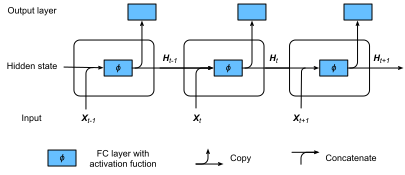

In [6]:
from IPython.display import SVG
SVG(filename="../img/rnn.svg")

As discussed, the computation in the hidden state uses H<sub>t</sub> = X<sub>t</sub>W<sub>xh</sub> + H<sub>t-1</sub>W<sub>hh</sub> to generate an object matching H<sub>t-1</sub>
in dimensionality. Moreover, we use H<sub>t</sub> to generate the output O<sub>t</sub> = H<sub>t</sub>W<sub>hq</sub>.

In [7]:
import torch
import torch.nn as nn

In [38]:
X=torch.randn(3,1)
H=torch.randn(3,2)

W_xh=torch.randn(1,2)
W_hh=torch.randn(2,2)
W_hq=torch.randn(2,3)

def net(X, H):
    H = (torch.mm(X, W_xh) + torch.mm(H, W_hh))
    O = (torch.mm(H, W_hq))
    return H, O

The recurrent network defined above takes observations X and a hidden state H as arguments and uses them to update the
hidden state and emit an output O. Since this chain could go on for a very long time, training the model with backprop is
out of the question (at least without some approximation). After all, this leads to a very long chain of dependencies that
would be prohibitive to solve exactly: books typically have more than 100,000 characters and it is unreasonable to assume
that the later text relies indiscriminately on all occurrences that happened, say, 10,000 characters in the past. Truncation
methods such as BPTT  and long short term memory are useful to address this in a more
principled manner. For now, let’s see how a state update works.

In [39]:
(H, O) = net(X,H)

print(H)
print(O)

tensor([[-0.1791, -1.1110],
        [ 1.8311, -4.8133],
        [ 0.1405,  2.0094]])
tensor([[ 1.4982, -0.4124,  0.5771],
        [ 2.0720, -1.2001,  2.6391],
        [-2.3988,  0.7046, -1.0535]])


## Steps in a Language Model

We conclude this section by illustrating how RNNs can be used to build a language model. For simplicity of illustration
we use words rather than characters, since the former are easier to comprehend. Let the number of mini-batch examples
be 1, and the sequence of the text be the beginning of our dataset, i.e. “the time machine by h. g. wells”. The figure below
illustrates how to estimate the next character based on the present and previous characters. During the training process,
we run a softmax operation on the output from the output layer for each time step, and then use the cross-entropy loss
function to compute the error between the result and the label. Due to the recurrent computation of the hidden state in
the hidden layer, the output of time step 3 O<sub>3</sub> is determined by the text sequence “the”, “time”, “machine”. Since the
next word of the sequence in the training data is “by”, the loss of time step 3 will depend on the probability distribution
of the next word generated based on the sequence “the”, “time”, “machine” and the label “by” of this time step.

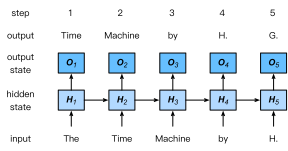

In [40]:
SVG(filename="../img/rnn-train.svg")

Word-level RNN language model. The input and label sequences are The Time Machine by H. and
Time Machine by H. G. respectively.

The number of words is huge compared to the number of characters. This is why quite often  we will use a character-level RNN instead. In the next few sections, we will introduce its implementation.

## Summary

* A network that uses recurrent computation is called a recurrent neural network (RNN).
* The hidden state of the RNN can capture historical information of the sequence up to the current time step.
* The number of RNN model parameters does not grow as the number of time steps increases.
* We can create language models using a character-level RNN.

## Exercises

1. If we use an RNN to predict the next character in a text sequence, how many output dimensions do we need?
2. Can you design a mapping for which an RNN with hidden states is exact? Hint - what about a finite number of
words?
3. What happens to the gradient if you backpropagate through a long sequence?
4. What are some of the problems associated with the simple sequence model described above?